# Scan document rotation 

We often misplace the document in the scanning area of the printer. That is why this project was created. It's aim was to train a neural network that would allow the rotation of scanned documents according to our reading direction. I used the template from the tutorial to train the network: https://www.tensorflow.org/tutorials/images/classification. 


## Import TensorFlow and other libraries# Import libs 

In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import argparse
import shutil
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import backend as K

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [2]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Prepare data

Download data set: https://www.cs.cmu.edu/~aharley/rvl-cdip/ 

We start data processing by unpacking them with 7-zip, allowing a flat view (as shown in the picture). This facilitated future file extraction from nested directories. Now you can extract the files to the target folder. Set the specified filenames to be automatically changed on the first error during extraction. Run first script to remove empty directories  and unnecessery files in your data folder. 

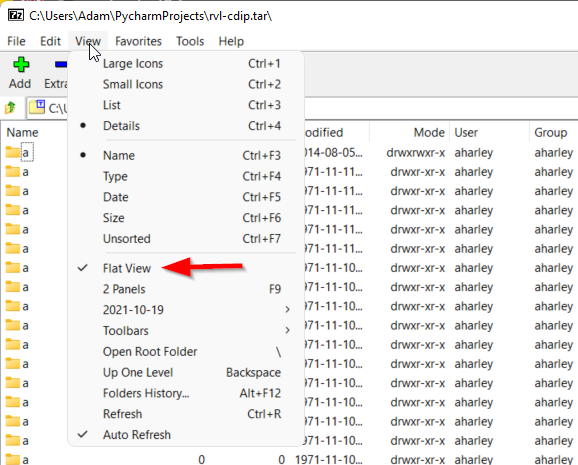


In [ ]:
%cd "C:\Users\Adam\PycharmProjects\rvl-cdip"
# remove destroyed file
#os.remove("2500126531_2500126536.tif")

In [ ]:
# script 1 - change working directory

# delete empty directories
for entry in os.scandir("./"):
    if os.path.isdir(entry.path) and not os.listdir(entry.path) :
        os.rmdir(entry.path)


# remove txt files - these were labels for dataset
for infile in os.listdir("./"):
    if infile[-3:] == "txt":
       os.remove(infile)

In [ ]:
# convert tif files to jpeg
#it is posible that you have to run this cell in python file becouse of dying kernel
n = 1
print(n)
for infile in os.listdir("./"):
    #print("w for")
    
    if infile[-3:] == "tif":
        #print("w if")
        outfile = infile[:-3] + "jpeg"
        im = Image.open(infile)
        out = im.convert("RGB")
        out.save(outfile, "JPEG", quality=90)
        os.remove(infile)
        n = n + 1
        #print(n)

print("end")

## Rotate documents

Now we create four subfolders and rotate the scans. The files may have been rotated before to our process, however after a quick research I found this to be a relatively small factor and decided to retrain the web despite this fact.

In [ ]:
# create subfolders and move files into these

N = len([name for name in os.listdir('.') if os.path.isfile(name)]) // 4  # the number  files in all 4 subfolder folder
print(N)
def move_files(abs_dirname):
    """Move files into subdirectories."""

    files = [os.path.join(abs_dirname, f) for f in os.listdir(abs_dirname)]

    i = 0
    curr_subdir = None

    for f in files:
        # create new subdir if necessary
        if i % N == 0:
            subdir_name = os.path.join(abs_dirname, '{0:03d}'.format(int(90 * i // N )))
            os.mkdir(subdir_name)
            curr_subdir = subdir_name

        # move file to current dir
        f_base = os.path.basename(f)
        shutil.move(f, os.path.join(subdir_name, f_base))
        i += 1


def parse_args():
    """Parse command line arguments passed to script invocation."""
    parser = argparse.ArgumentParser(
        description='Split files into multiple subfolders.')

    parser.add_argument('src_dir', help='source directory')

    return parser.parse_args()


def run():
    
    src_dir = "./"

    if not os.path.exists(src_dir):
        raise Exception('Directory does not exist ({0}).'.format(src_dir))

    move_files(os.path.abspath(src_dir))
run()
# remove directory where are only 3 files
shutil.rmtree("./360")


In [ ]:
# Rotate files according to folder name
# 90 degrees
%cd "C:\Users\Adam\PycharmProjects\rvl-cdip\090"

def rotateImages(rotationAmt):
    n = 0
    # for each image in the current directory
    for image in os.listdir("./"):
    
    # open the image
        img = Image.open(image)
    # rotate and save the image with the same filename
        img.rotate(rotationAmt, expand=True).save(image)
    # close the image
        img.close()
        n = n + 1
        print(n)
rotateImages(90)

In [ ]:
# Rotate files according to folder name
# 180 degrees

%cd "C:\Users\Adam\PycharmProjects\rvl-cdip\180"

def rotateImages(rotationAmt):
    n = 0
    # for each image in the current directory
    for image in os.listdir("./"):
    
    # open the image
        img = Image.open(image)
    # rotate and save the image with the same filename
        img.rotate(rotationAmt, expand=True).save(image)
    # close the image
        img.close()
        n = n + 1
        print(n)
rotateImages(180)

In [ ]:
# Rotate files according to folder name
# 270 degrees
%cd "C:\Users\Adam\PycharmProjects\rvl-cdip\270"

def rotateImages(rotationAmt):
    
    n = 0
    # for each image in the current directory
    
    for image in os.listdir("./"):
    # open the image
        img = Image.open(image)
    # rotate and save the image with the same filename
        img.rotate(rotationAmt, expand=True).save(image)
    # close the image
        img.close()
        n = n + 1
        print(n)
rotateImages(270)

# Machine learning

Now we have a dataset of about 400,000 photos of documents. The dataset contains 4 sub-directories, one per class:

```
rvl-cdip/
  000/
  090/
  180/
  270/
```

In [5]:
data_dir = r"C:\Users\Adam\PycharmProjects\rvl-cdip"
data_dir = pathlib.Path(data_dir)

# Count scans
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

399999


Here are some scan rotated documents:

In [ ]:
docs_180 = list(data_dir.glob('180/*'))
PIL.Image.open(str(docs_180[0]))
PIL.Image.open(str(docs_180[122]))

docs_090 = list(data_dir.glob('090/*'))
PIL.Image.open(str(docs_090[110]))

And some documents rotated by 90 degrees:

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. 

## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 90
img_width = 90

Separate data. I use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 399999 files belonging to 4 classes.
Using 320000 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 399999 files belonging to 4 classes.
Using 79999 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [9]:
class_names = train_ds.class_names
print(class_names)

['000', '090', '180', '270']


## Visualize the data

Here are the first 9 images from the training dataset.

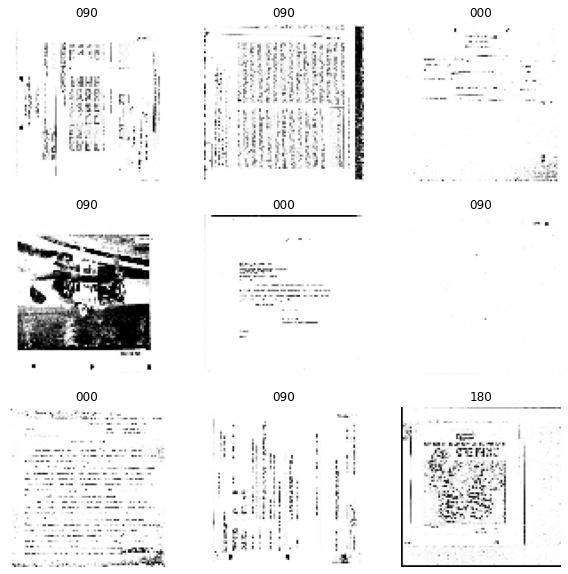

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 90, 90, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.00074055995 1.0


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. 

In [15]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

## Train the model

In [18]:
K.clear_session()
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
10000/10000 [==============================] - 408s 35ms/step - loss: 0.2665 - accuracy: 0.9028 - val_loss: 0.1705 - val_accuracy: 0.9401
Epoch 2/5
10000/10000 [==============================] - 234s 23ms/step - loss: 0.1418 - accuracy: 0.9508 - val_loss: 0.1536 - val_accuracy: 0.9470
Epoch 3/5
10000/10000 [==============================] - 246s 25ms/step - loss: 0.1022 - accuracy: 0.9643 - val_loss: 0.1559 - val_accuracy: 0.9504
Epoch 4/5
10000/10000 [==============================] - 248s 25ms/step - loss: 0.0765 - accuracy: 0.9732 - val_loss: 0.1595 - val_accuracy: 0.9523
Epoch 5/5
10000/10000 [==============================] - 245s 24ms/step - loss: 0.0579 - accuracy: 0.9798 - val_loss: 0.1770 - val_accuracy: 0.9533


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')


In [19]:
model.save('my_model.h5')

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In [ ]:

import tensorflow as tf

import os
dir = os.path.dirname(os.path.realpath(__file__))

# Currently, we are in the default graph scope

# Let's design some variables
v1 = tf.Variable(1. , name="v1")
v2 = tf.Variable(2. , name="v2")
# Let's design an operation
a = tf.add(v1, v2)

# We can check easily that we are indeed in the default graph
print(a.graph == tf.get_default_graph())
# -> True

# Let's create a Saver object
# By default, the Saver handles every Variables related to the default graph
all_saver = tf.train.Saver() 
# But you can precise which vars you want to save (as a list) and under which name (with a dict)
v2_saver = tf.train.Saver({"v2": v2}) 


# By default the Session handles the default graph and all its included variables
with tf.Session() as sess:
  # Init v1 and v2   
  sess.run(tf.global_variables_initializer())
  # Now v1 holds the value 1.0 and v2 holds the value 2.0
  # and we can save them
  all_saver.save(sess, dir + '/data-all')
  # or saves only v2
  v2_saver.save(sess, dir + '/data-v2')

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPoolin

In [ ]:
g2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)